In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


from DMS2_multiday_plots_utils import *
# from DMS2_fetch_protocol_data import *
from dj_utils import return_date_window
# settings
%load_ext autoreload
%autoreload 2

sns.set_context("talk")
# ratinfo = dj.create_virtual_module("intfo", "ratinfo")

# from DMS2_fetch_daily_summary_data import fetch_daily_summary_info

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def create_figure(figsize=(10, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    return fig, ax

In [9]:
date_min, date_max = return_date_window(latest_date=None, n_days_back=20)

In [40]:
df = fetch_latest_trials_data(
    animal_ids=None, 
    date_min=date_min, 
    date_max=date_max
)
r610 = df.query("animal_id == 'R610'")

fetched 19 sessions for R610 between 2023-05-01 and 2023-05-19
fetched 19 sessions for R611 between 2023-05-01 and 2023-05-19
fetched 19 sessions for R612 between 2023-05-01 and 2023-05-19
fetched 19 sessions for R613 between 2023-05-01 and 2023-05-19
fetched 19 sessions for R614 between 2023-05-01 and 2023-05-19


In [5]:
df = fetch_daily_summary_info(animal_ids=["R610"], date_min="2023-05-01")

fetched 18 daily summaries for R610 between 2023-05-01 and 2023-05-18


In [3]:
# df.to_csv('df.csv', index=False) # already ran this
df = pd.read_csv('df.csv') # run if needed
r610 = df.query("animal_id == 'R610'")

sum_df = pd.read_csv('summary_df.csv')
sum_r610 = sum_df.query("animal_id == 'R610'")

## Trials Plot

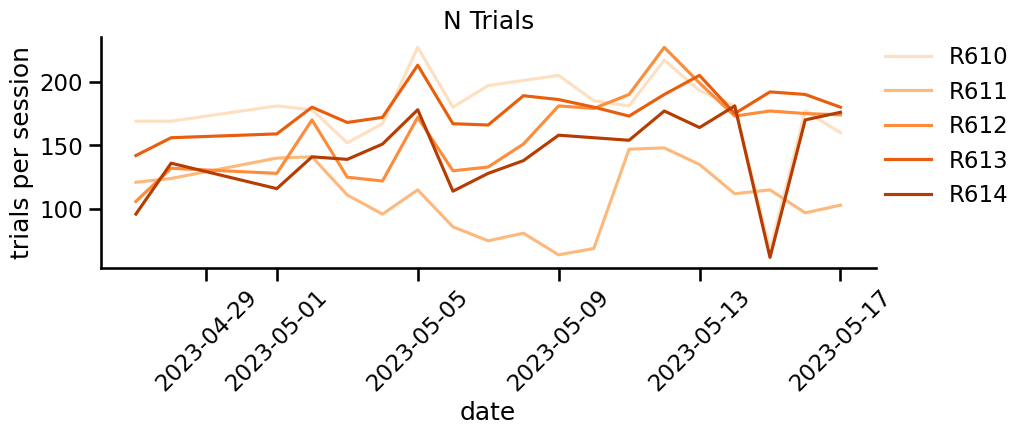

In [52]:
fig,ax = create_figure()
plot_multianimal_trials(df, ax)


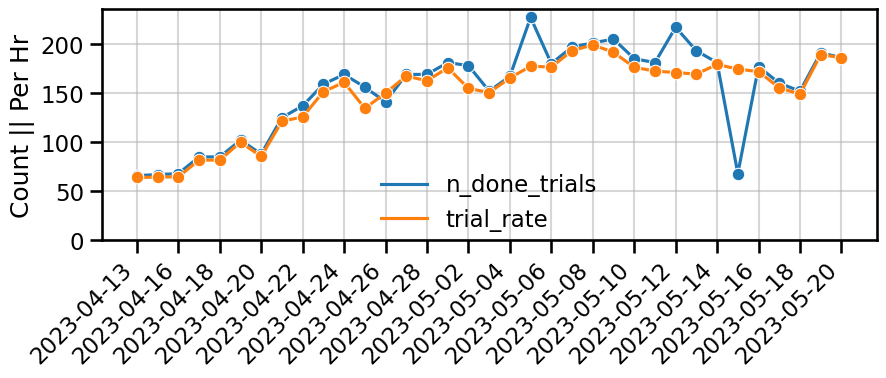

In [28]:
fig, ax = create_figure()

plot_multiday_trials(sum_r610, ax,legend=True)

## Stage plots

In [45]:
df["animal_id"] = df["animal_id"].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14786 entries, 0 to 2782
Data columns (total 61 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   trial                 14786 non-null  int64   
 1   animal_id             14786 non-null  object  
 2   date                  14786 non-null  object  
 3   sess_id               14786 non-null  int64   
 4   result                14786 non-null  Int64   
 5   hits                  7782 non-null   Int64   
 6   violations            14781 non-null  Int64   
 7   temperror             7782 non-null   Int64   
 8   hit_rate              14593 non-null  float64 
 9   error_rate            14593 non-null  float64 
 10  violation_rate        14786 non-null  float64 
 11  temp_error_rate       14593 non-null  float64 
 12  n_lpokes              14738 non-null  float64 
 13  n_cpokes              14738 non-null  float64 
 14  n_rpokes              14738 non-null  float64 
 15  trial_du

TypeError: Could not convert R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610R610 to numeric

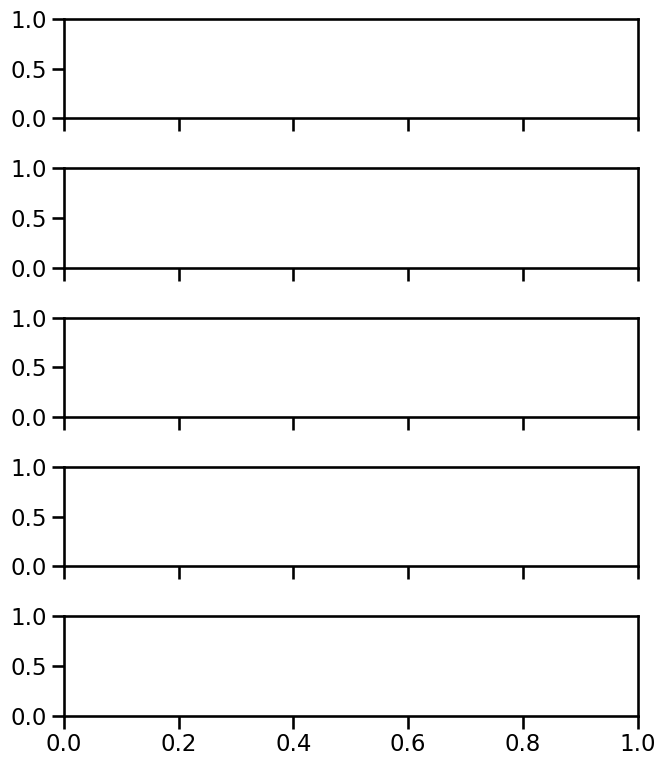

In [42]:
fig,ax=plt.subplots(5,1, figsize=(7,8), sharey=True, sharex=True)
plt.tight_layout()
for ii, (animal_id,sub_df) in enumerate(df.groupby("animal_id")):
    plot_stage(sub_df, ax[ii])
    # ax[ii].set(ylim=(0,5), ylabel="")
    None

In [8]:
"""Not working"""
def plot_trials_in_stage(df, ax, title=None):
    sub_df.groupby("stage").sum().trial.plot(kind="bar",ax=ax)


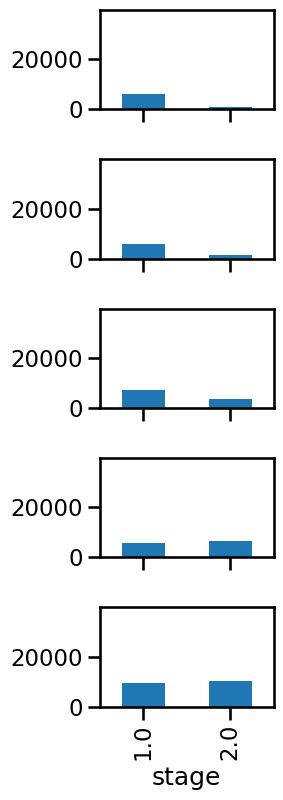

In [9]:
fig,ax=plt.subplots(5,1, figsize=(3,8), sharey=True, sharex=True)
plt.tight_layout()
for ii, (animal_id,sub_df) in enumerate(df.groupby(["animal_id"])):
    plot_trials_in_stage(sub_df, ax[ii], title=animal_id)
    ax[ii].set(ylabel="")
    None

## Bias Plots

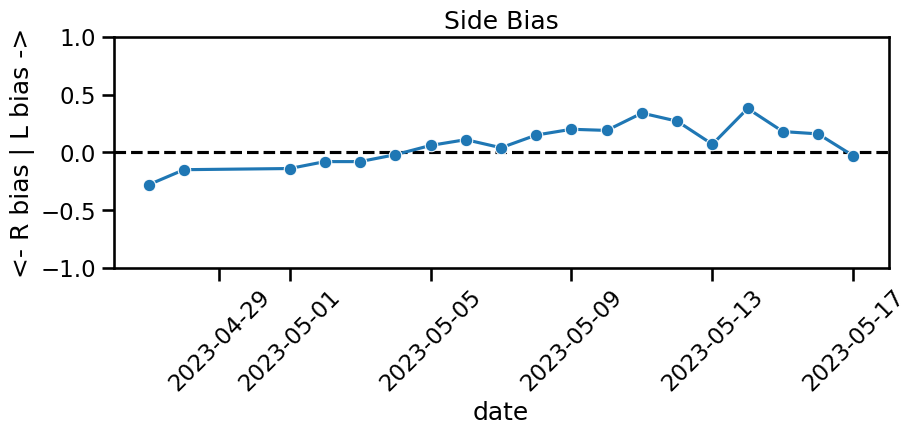

In [53]:
fig,ax = create_figure()
plot_multiday_side_bias(r610, ax)


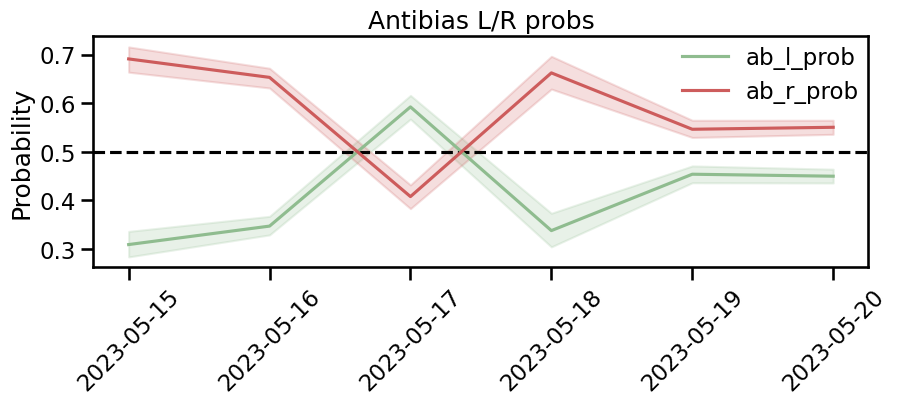

In [38]:
fig,ax = plt.subplots(figsize=(10,3))

plot_multiday_antibias_probs(r610, ax)

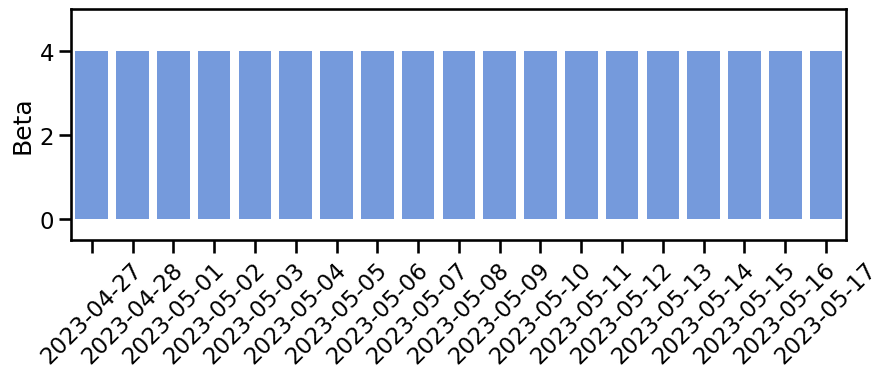

In [54]:
fig,ax = create_figure()

plot_multiday_antibias_beta(r610, ax)

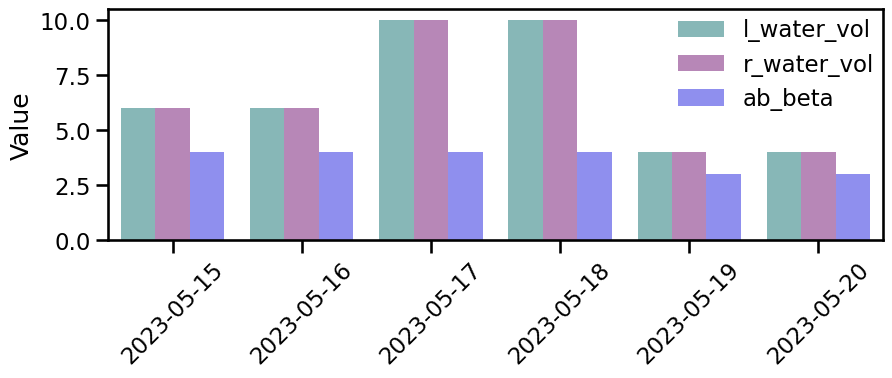

In [37]:
fig,ax= create_figure()

plot_multiday_sidebias_params(r610, ax, legend=True)


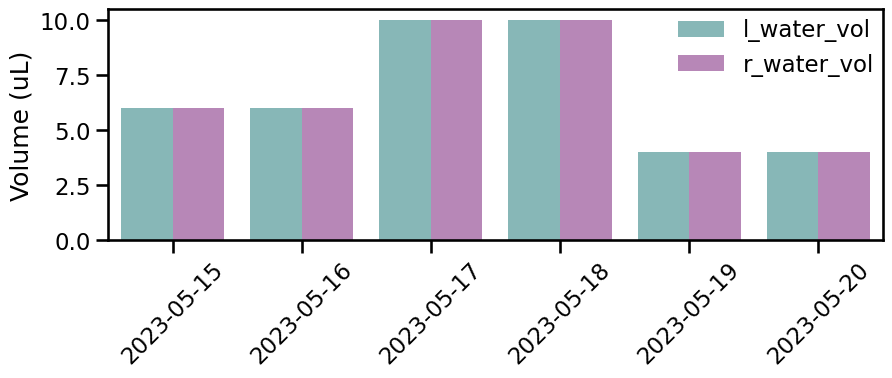

In [16]:
fig,ax = create_figure()
plot_multiday_water_vols(r610, ax)

## Water & Mass plots

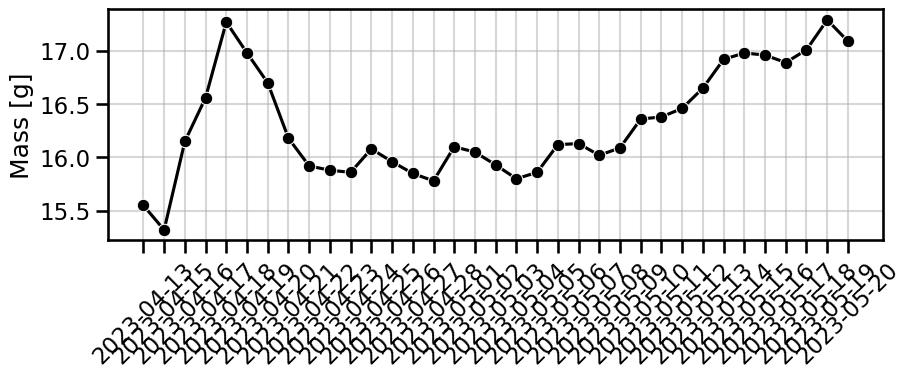

In [46]:
fig,ax = create_figure()
plot_multiday_mass(sum_r610, ax)


In [49]:
sum_r610.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 0 to 34
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   animal_id       35 non-null     object 
 1   date            35 non-null     object 
 2   rigid           35 non-null     object 
 3   n_done_trials   35 non-null     int64  
 4   n_sessions      35 non-null     int64  
 5   start_time      35 non-null     object 
 6   train_dur_hrs   35 non-null     float64
 7   trial_rate      35 non-null     float64
 8   mass            35 non-null     float64
 9   tech            35 non-null     object 
 10  percent_target  35 non-null     float64
 11  pub_volume      35 non-null     float64
 12  rig_volume      35 non-null     float64
 13  volume_target   35 non-null     float64
 14  water_diff      35 non-null     float64
dtypes: float64(8), int64(2), object(5)
memory usage: 4.4+ KB


In [60]:
wm

,date,variable,water_info
0,2023-04-13,rig_volume,0.620
1,2023-04-15,rig_volume,1.040
2,2023-04-16,rig_volume,0.945
3,2023-04-17,rig_volume,1.275
4,2023-04-18,rig_volume,0.840
...,...,...,...
65,2023-05-16,pub_volume,0.447
66,2023-05-17,pub_volume,0.000
67,2023-05-18,pub_volume,0.000
68,2023-05-19,pub_volume,0.285


In [41]:
sum_r610.columns

Index(['animal_id', 'date', 'rigid', 'n_done_trials', 'n_sessions',
       'start_time', 'train_dur_hrs', 'trial_rate', 'mass', 'tech',
       'percent_target', 'pub_volume', 'rig_volume', 'volume_target',
       'water_diff'],
      dtype='object')

In [51]:
sum_r610

,animal_id,date,rigid,n_done_trials,n_sessions,start_time,train_dur_hrs,trial_rate,mass,tech,percent_target,pub_volume,rig_volume,volume_target,water_diff
0,R610,2023-04-13,Rig406,66,1,10:14:54,1.03,64.08,15.55,JL,0.0,0.000,0.620,0.62,0.000
1,R610,2023-04-15,Rig406,67,1,11:15:11,1.04,64.42,15.32,AB,4.0,0.000,1.040,0.61,0.430
2,R610,2023-04-16,Rig406,68,1,10:52:54,1.05,64.76,16.15,ER,4.0,0.000,0.945,0.65,0.295
3,R610,2023-04-17,Rig406,85,1,09:44:17,1.04,81.73,16.56,JL,4.0,0.000,1.275,0.66,0.615
4,R610,2023-04-18,Rig406,85,1,10:05:05,1.04,81.73,17.27,JL,4.0,0.000,0.840,0.69,0.150
5,R610,2023-04-19,Rig406,102,1,10:40:06,1.02,100.00,16.98,ER,4.0,0.000,1.030,0.68,0.350
6,R610,2023-04-20,Rig406,88,1,08:28:46,1.03,85.44,16.70,ER,4.0,0.000,0.700,0.67,0.030
7,R610,2023-04-21,Rig406,125,1,08:32:36,1.03,121.36,16.18,ER,4.0,0.000,1.030,0.65,0.380
8,R610,2023-04-22,Rig406,137,1,11:11:19,1.09,125.69,15.92,ER,4.0,0.000,0.968,0.64,0.328
9,R610,2023-04-23,Rig406,159,1,10:09:45,1.05,151.43,15.88,ER,4.0,0.000,1.200,0.64,0.560


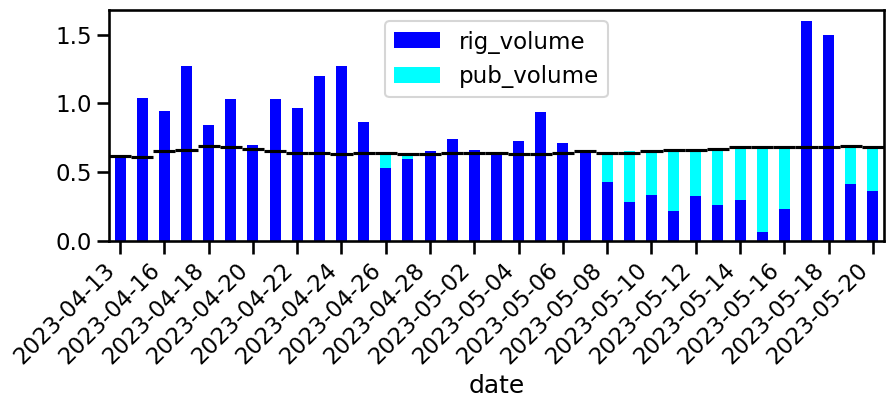

In [64]:
fig,ax = create_figure()

# Create stacked bar chart
columns_to_plot = ["date", "rig_volume", "pub_volume"] 
sum_r610[columns_to_plot].plot(x="date", kind="bar", stacked=True,color=["blue", "cyan"],ax=ax)

# iterate over dates to plot volume target
for i in range(len(sum_r610)):
    ax.hlines(y = sum_r610.volume_target[i], xmin = i-0.5, xmax = i+0.5,
              color = 'black')

set_date_x_ticks(ax, everyother=True)


### TODO
* water plot with pub water
* mass plot (kinda related^)

## Trial result plot

In [32]:
x = r610.groupby(["date"]).result.value_counts(normalize="True").reset_index(["date"])


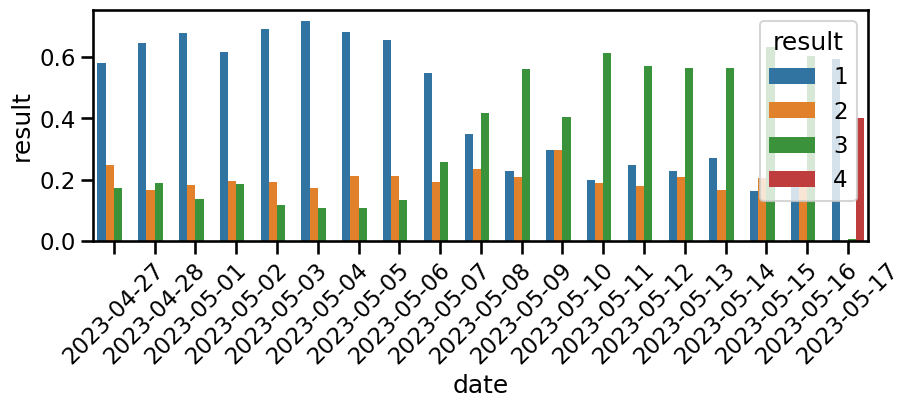

In [33]:
fig,ax= plt.subplots(figsize=(10,3))
sns.barplot(data=x, x="date", y="result", hue=x.index,ax=ax)
ax.tick_params(axis="x", labelrotation=45)


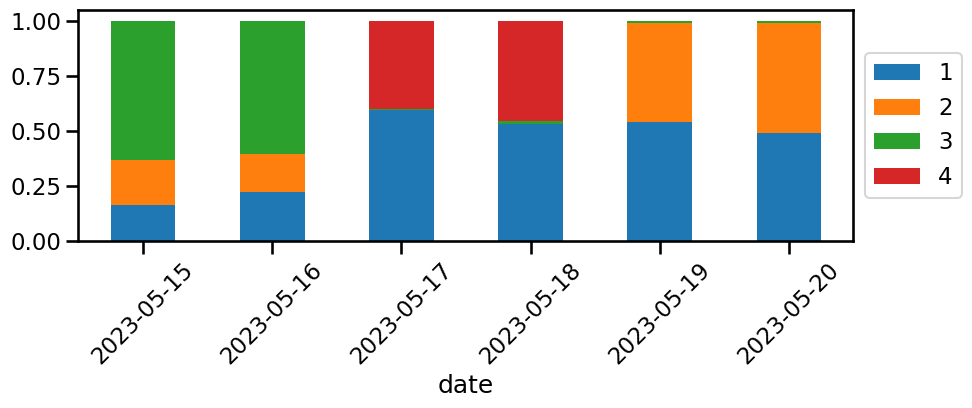

In [47]:
# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 3))
y = r610.groupby(["date"]).result.value_counts(normalize=True).unstack()
y.plot(kind='bar', stacked=True, ax=ax)

# Rotate x-axis labels
ax.tick_params(axis="x", labelrotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

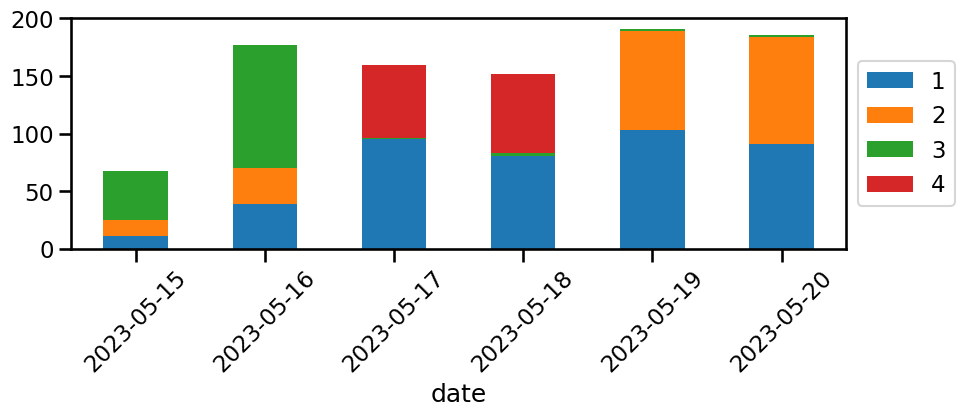

In [33]:
z = r610.groupby(["date"]).result.value_counts().unstack()
fig, ax = plt.subplots(figsize=(10, 3))
z.plot(kind='bar', stacked=True, ax=ax)

# Rotate x-axis labels
ax.tick_params(axis="x", labelrotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

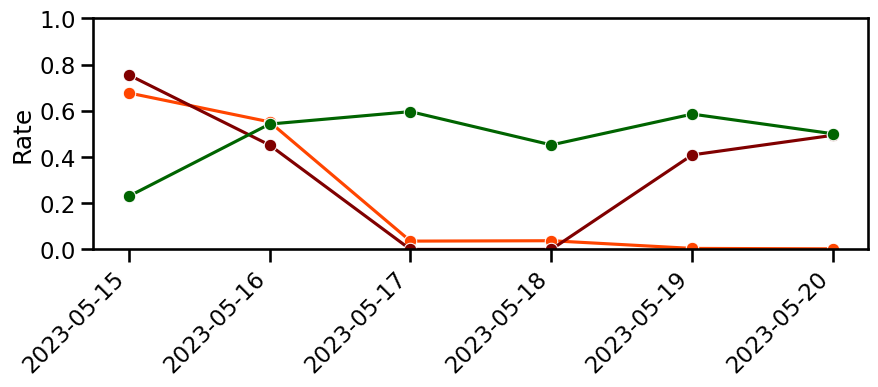

In [32]:
fig,ax = plt.subplots(figsize =(10,3))

plot_multiday_perfs(r610, ax)


## Timing Params

-pre_go, viol_dur, delay_dur (all on one plot?)
- cumulative delay_dur, colored by was_violation or was_noanswers

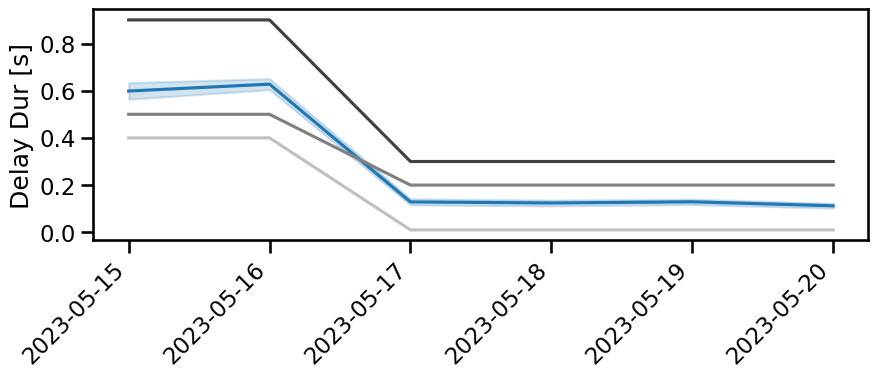

In [31]:
fig, ax = create_figure()

plot_multiday_delay_params(r610, ax)

## Rig & Tech

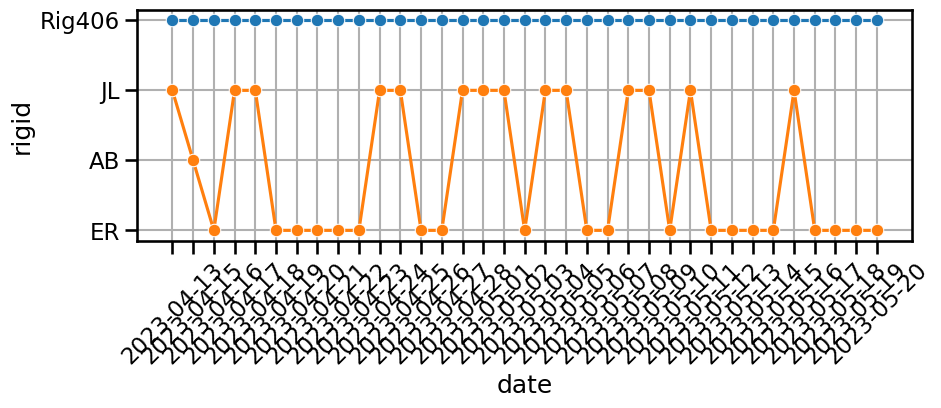

In [74]:
fig,ax = create_figure()
# TODO make this into a function

sns.lineplot(data=sum_r610, x="date", y="rigid", marker="o",ax=ax)
sns.lineplot(data=sum_r610, x="date", y="tech",marker="o",ax=ax)

ax.tick_params(axis="x", labelrotation=45)
ax.grid() # todo make this x only maybe?
